# Imports

In [1]:
import scipy.io
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time # spooky

RNDS = 1389

# Data

In [2]:
mat_data = scipy.io.loadmat('./data/mnistAll.mat')
mnist_data = mat_data['mnist']

In [3]:
# load images
train_images = mnist_data['train_images'][0, 0].T.squeeze()
test_images = mnist_data['test_images'][0, 0].T.squeeze()
train_labels = mnist_data['train_labels'][0, 0].T.squeeze()
test_labels = mnist_data['test_labels'][0, 0].T.squeeze()
# find idxs that are of 3 and 7
train_filter = np.where((train_labels == 3) | (train_labels == 7))[0].squeeze()
test_filter = np.where((test_labels == 3) | (test_labels == 7))[0]

# filter only images and labels of 3 and 7
train_images = train_images[train_filter]
train_labels = train_labels[train_filter]
test_images = test_images[test_filter]
test_labels = test_labels[test_filter]

# split train into train and val
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=RNDS)

print(train_images.shape, val_images.shape, test_images.shape, train_labels.shape, val_labels.shape, test_labels.shape)

(9916, 28, 28) (2480, 28, 28) (2038, 28, 28) (9916,) (2480,) (2038,)


In [4]:
# scale inputs to be between 0 and 1
train_images = train_images.astype(float) / 255.0 # 255 because greyscale images
val_images = val_images.astype(float) / 255.0
test_images = test_images.astype(float) / 255.0

print(train_images[0], val_images[0], test_images[0])

# scale classes to be 0 and 1 as well
train_labels = np.where(train_labels == 3, 0, 1)
val_labels = np.where(val_labels == 3, 0, 1)
test_labels = np.where(test_labels == 3, 0, 1)

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.25098039 0.25098039 0.         0.
  0.         0.    

## Gradient Descent

In [5]:
# sigmoid function
def sigma(x):
    return 1.0 / (1.0 + np.exp(-x))

# predict function
def predict(x, w):
    return sigma(np.dot(x, w))

# negative log likelihood
def NLL(y_pred, t):
    return -np.mean(t * np.log(y_pred) + (1 - t) * np.log(1 - y_pred))

# gradient with respect to weights
def gradient(x, y_pred, t):
    return np.dot(x.T, (y_pred - t)) / len(x)

def misclassification_rate(y_pred, t):
    # convert predictions to binary labels
    y_labels = (y_pred >= 0.5).astype(int)
    return np.mean(y_labels != t)

In [6]:
# gradient descent training with early stopping
def train(x, t, w, learning_rate, epochs, x_val=None, t_val=None):
    train_errors = []
    val_errors = []
    
    best_train_error = float('inf')
    best_val_error = float('inf')
    
    for epoch in range(epochs):
        y_pred = predict(x, w)
        current_train_error = NLL(y_pred, t)
        train_errors.append(current_train_error)
        
        best_train_error = min(best_train_error, current_train_error)
        
        if x_val is not None and t_val is not None:
            y_val_pred = predict(x_val, w)
            current_val_error = NLL(y_val_pred, t_val)
            val_errors.append(current_val_error)
        
            # Early stopping
            if current_val_error > best_val_error:
                break
            
            best_val_error = min(best_val_error, current_val_error)
        
        grad = gradient(x, y_pred, t)
        w -= learning_rate * grad
    
    return w, train_errors, val_errors, best_train_error, best_val_error

In [7]:
# set random seed for reproducibility
np.random.seed(RNDS)

# flatten and add a bias term to the images
train_images_flat = train_images.reshape(train_images.shape[0], -1)
val_images_flat = val_images.reshape(val_images.shape[0], -1)
test_images_flat = test_images.reshape(test_images.shape[0], -1)

train_images_bias = np.c_[np.ones((train_images_flat.shape[0], 1)), train_images_flat]
val_images_bias = np.c_[np.ones((val_images_flat.shape[0], 1)), val_images_flat]
test_images_bias = np.c_[np.ones((test_images_flat.shape[0], 1)), test_images_flat]

# Random initial weights
w_init = np.random.randn(train_images_bias.shape[1])

learning_rates = [0.001, 0.01, 0.1]

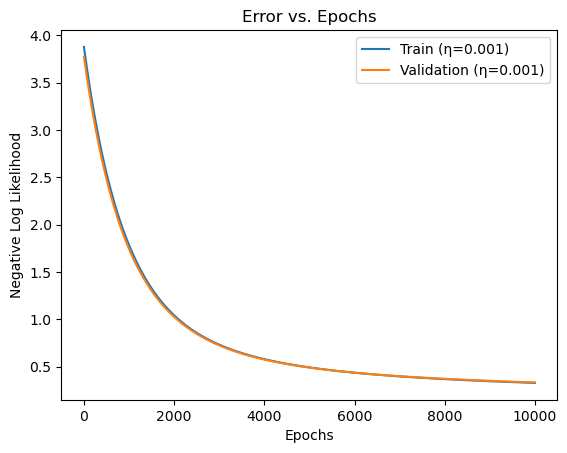

Best training error with learning rate 0.001: 0.3278450284937915
Best validation error with learning rate 0.001: 0.33274620850323594
Test error with learning rate 0.001: 0.346877644376972
Training misclassification rate: 0.08884630899556273
Validation misclassification rate: 0.08629032258064516
Test misclassification rate: 0.08194308145240432
Training time for learning rate 0.001: 63.60359716415405 seconds


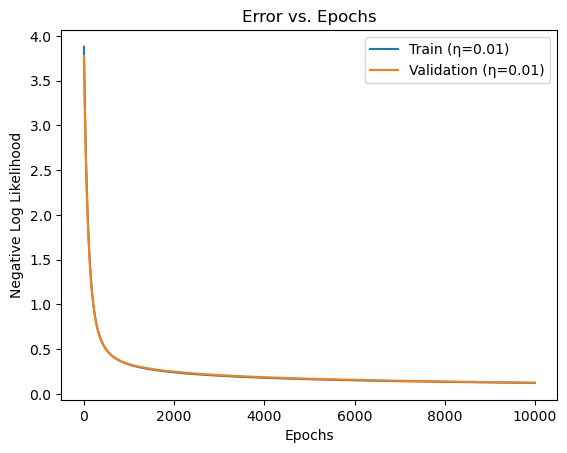

Best training error with learning rate 0.01: 0.12199507427174404
Best validation error with learning rate 0.01: 0.12449225757241093
Test error with learning rate 0.01: 0.15924004564614716
Training misclassification rate: 0.03227107704719645
Validation misclassification rate: 0.03467741935483871
Test misclassification rate: 0.03876349362119725
Training time for learning rate 0.01: 61.83850955963135 seconds


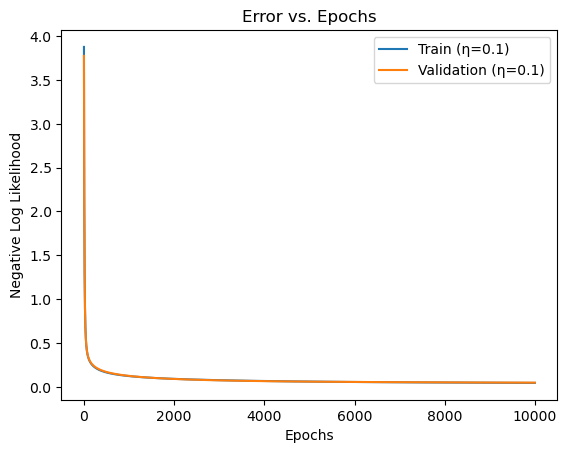

Best training error with learning rate 0.1: 0.0444255171631849
Best validation error with learning rate 0.1: 0.04758616563941391
Test error with learning rate 0.1: 0.07046595560861853
Training misclassification rate: 0.01300927793465107
Validation misclassification rate: 0.01532258064516129
Test misclassification rate: 0.020608439646712464
Training time for learning rate 0.1: 61.392712116241455 seconds


In [8]:
# training loop
for eta in learning_rates:
    start_time = time.time()
    
    w, train_errors, val_errors, best_train_error, best_val_error = train(train_images_bias, train_labels, w_init.copy(), eta, 10000, val_images_bias, val_labels)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    plt.plot(train_errors, label=f'Train (η={eta})')
    plt.plot(val_errors, label=f'Validation (η={eta})')
    plt.xlabel('Epochs')
    plt.ylabel('Negative Log Likelihood')
    plt.legend()
    plt.title('Error vs. Epochs')
    plt.show()
    
    y_train_pred = predict(train_images_bias, w)
    train_misclass_rate = misclassification_rate(y_train_pred, train_labels)
    
    y_val_pred = predict(val_images_bias, w)
    val_misclass_rate = misclassification_rate(y_val_pred, val_labels)
    
    y_test_pred = predict(test_images_bias, w)
    test_error = NLL(y_test_pred, test_labels)
    test_misclass_rate = misclassification_rate(y_test_pred, test_labels)
    
    print(f"Best training error with learning rate {eta}: {best_train_error}")
    print(f"Best validation error with learning rate {eta}: {best_val_error}")
    print(f"Test error with learning rate {eta}: {test_error}")
    print(f"Training misclassification rate: {train_misclass_rate}")
    print(f"Validation misclassification rate: {val_misclass_rate}")
    print(f"Test misclassification rate: {test_misclass_rate}")
    print(f"Training time for learning rate {eta}: {elapsed_time} seconds")